# Movie Recommendation System

The movie dataset can be downloaded in the following links:
- [tmdb_5000_movies.csv](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?resource=download)
- [tmdb_5000_credits.csv](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?resource=download)
- ratings_df: several resources use a ratings.csv that I was not able to find, so I randomly generate the missing data in the cells below


We will use the following algorithms:
- Demographic Filtering
- Content Based Filtering
- Collaborative Filtering


References:
- [kaggle](https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook)
- [freeCodeCamp](https://www.freecodecamp.org/news/how-to-build-a-movie-recommendation-system-based-on-collaborative-filtering/)
- [geeksforgeeks](https://www.geeksforgeeks.org/user-based-collaborative-filtering/)
- [hackernoon](https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75)
- [machinelearningmastery](https://machinelearningmastery.com/using-singular-value-decomposition-to-build-a-recommender-system/#:~:text=Singular%20value%20decomposition%20is%20a,be%20build%20easily%20from%20this.
)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# Get data & EDA

In [4]:
movies_df = pd.read_csv('NonUploadedData/tmdb_5000_movies.csv')
credits_df = pd.read_csv('NonUploadedData/tmdb_5000_credits.csv')

In [5]:
movies_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [6]:
credits_df.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')
# keep only a few
df = df[['title_x', 'budget', 'genres', 'keywords', 'original_language', 'revenue', 'vote_count', 'vote_average']].copy()
df['revenue'] = df['revenue'].astype(float)
df.head(4)

,title_x,budget,genres,keywords,original_language,revenue,vote_count,vote_average
0,Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,2.787965e+09,11800,7.2
1,Pirates of the Caribbean: At World's End,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,9.610000e+08,4500,6.9
2,Spectre,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,8.806746e+08,4466,6.3
3,The Dark Knight Rises,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,1.084939e+09,9106,7.6


In [8]:
df.shape

(4803, 8)

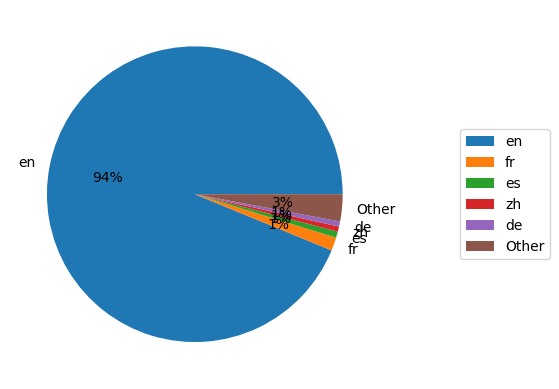

In [9]:
# display percentage by language
df_byLang = df['original_language'].value_counts().to_frame()
tot_others = df_byLang[df_byLang['original_language'] < 20].sum()
df_byLang = df_byLang.drop(df_byLang[df_byLang['original_language'] < 20].index)
df_byLang.loc['Other'] = tot_others
df_byLang.plot.pie(y='original_language', ylabel='', autopct='%1.0f%%')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))

No surprise here. <br />
Most of the reviewed movies are in English. <br />
Then, a small percentage in French, Spanish, Chinese, and German.

In [10]:
# movies with min and max revenues
df.sort_values(by='revenue', ascending=False)[:1][['title_x', 'revenue']]

,title_x,revenue
0,Avatar,2.787965e+09


In [11]:
df.sort_values(by='revenue', ascending=True)[:1][['title_x', 'revenue']]

,title_x,revenue
2401,City of Ghosts,0.0


The above is probably not true. Unless they didn't sell any tickets ...

Revenue = no of sales x price / sale <br />
Profit = Revenue - expenses <br />

So a revenue of 0 is suspicious.
It is probably missing data.

In [12]:
len(df[df['revenue'] == 0])

1427

This shows multiple entries with a 0 revenue. <br />
It is probably missing data.

Text(0.5, 0, 'revenue')

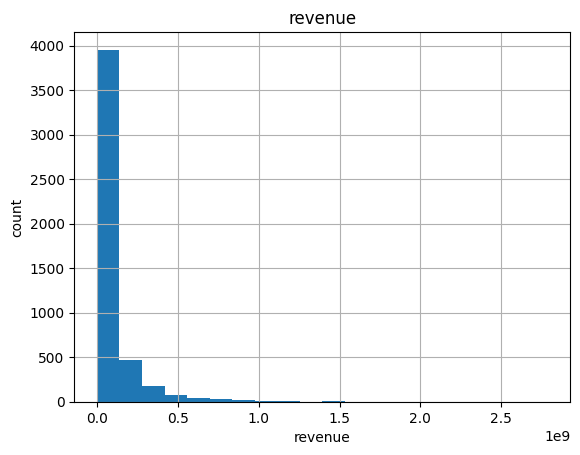

In [13]:
# histogram, count vs revenue
df.hist(column='revenue', bins=20)
plt.ylabel('count')
plt.xlabel('revenue')

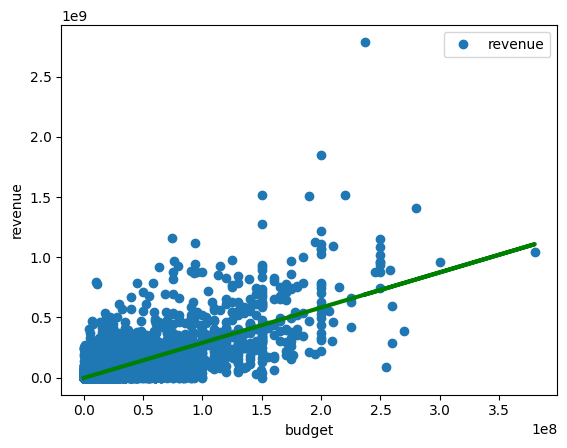

In [14]:
# let's see if the columns budget and revenue are somewhat correlated
from sklearn import linear_model

df.plot(x='budget', y='revenue', xlabel='budget', ylabel='revenue', style='o')
regr = linear_model.LinearRegression()
regr.fit(df[['budget']], df['revenue'])
plt.plot(df['budget'], regr.predict(df[['budget']]), color='green', linewidth=3)

In [15]:
from sklearn.metrics import r2_score

y_pred = regr.predict(df[['budget']])
r2_score(df['revenue'], y_pred)

0.5341020482032326

This plot shows that the revenue and budget are somewhat correlated. <br />
But the plot shows that not always a larger budget means larger revenue.

# Generate missing data

In [2]:
# we could use np.random.randint to produec userId, but it will produce
# a balanced list, something closer to a uniform distribution
userId = []
for i in range(1, 100):
    userId += [i] * np.random.randint(5,20)
userId

[1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,


In [16]:
movieId = []
for i in movies_df['id']:
    movieId += [i] * np.random.randint(5,20)
movieId

[19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 19995,
 285,
 285,
 285,
 285,
 285,
 285,
 285,
 285,
 285,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 206647,
 49026,
 49026,
 49026,
 49026,
 49026,
 49026,
 49026,
 49026,
 49026,
 49026,
 49026,
 49529,
 49529,
 49529,
 49529,
 49529,
 49529,
 559,
 559,
 559,
 559,
 559,
 559,
 559,
 559,
 559,
 559,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 38757,
 99861,
 99861,
 99861,
 99861,
 99861,
 767,
 767,
 767,
 767,
 767,
 767,
 767,
 767,
 767,
 767,
 767,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 209112,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 1452,
 

In [17]:
rating = []
for i in range(0, 10):
    rating += [i*0.5] * np.random.randint(10, len(movieId))
rating

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [18]:
import random

n_userId = random.sample(userId*5, 5000)
n_movieId = random.sample(movieId, 5000)
n_rating = random.sample(rating, 5000)

In [63]:
ratings_df = pd.DataFrame(
    {'userId': n_userId,
     'movieId': n_movieId,
     'rating': n_rating,
    })
ratings_df.sort_values(by='userId', inplace=True)
ratings_df.head(3)

,userId,movieId,rating
1485,1,9899,0.5
2293,1,7516,2.0
3550,1,206197,2.5


# Demographic Filtering

Recommendations are given to every user based on movie popularity and/or genre. <br />
All users receive the same recommendation. <br />
Netflix does this by country. <br />
It shows the top 10 movies in the US, for example.

In [20]:
df[['title_x', 'vote_count', 'vote_average']].sort_values(by='vote_average', ascending=False)

,title_x,vote_count,vote_average
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3992,Sardaarji,2,9.5
...,...,...,...
3960,The Deported,0,0.0
4684,American Beast,0,0.0
3967,Four Single Fathers,0,0.0
4486,Naturally Native,0,0.0


Another option is to use a weighted rating, that is based on the number of votes for each movie.

# Content Based Filtering

The system recommends similar items to a particular item. <br />
For example, movies from the same main actor.

### 1st approach - compute pairwise similarity scores based on the plot description in the 'overview' column.

In [21]:
df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')
df['overview'] = df['overview'].fillna('')
df.head(4)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['overview'])
tfidf_matrix.shape

(4803, 20978)

In [23]:
# we will compute a similarity matrix
# by doing a dot product we can obtain the similarity between two movies
# we can do it with linear_kernel
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(4803, 4803)

<AxesSubplot:>

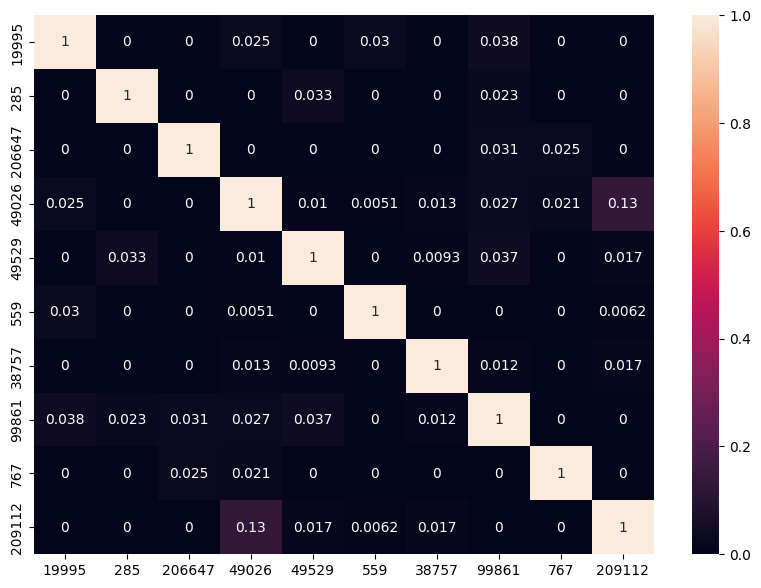

In [24]:
# let's look at a subset of movies
import seaborn as sn
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cosine_sim[:10,:10],
                     index = [i for i in df['id'][:10]],
                     columns = [i for i in df['id'][:10]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [25]:
# now let's create a function, that for a given movie 'title', it will provide a list of recommendations:
df2 = df.reset_index(names=['cosine_sim_matrix_id'])
df2.set_index('title_x', inplace=True)
df2.head(4)

,cosine_sim_matrix_id,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,movie_id,title_y,cast,crew
title_x,,,,,,,,,,,,,,,,,,,,,
Avatar,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
Pirates of the Caribbean: At World's End,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
Spectre,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
The Dark Knight Rises,3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."


In [26]:
def recommend_movie1(title):
    if title not in df2.index:
        print('movie not included')
        return

    id = df2.loc[title]['cosine_sim_matrix_id']
    recommend_df = pd.DataFrame({'title': df['title_x'], 'weight': cosine_sim[id]})
    recommend_df = recommend_df.sort_values(by='weight', ascending=False)
    return recommend_df[:10]

In [27]:
recommend_movie1('Avatar')

,title,weight
0,Avatar,1.000000
3604,Apollo 18,0.186810
2130,The American,0.170151
634,The Matrix,0.132307
1341,The Inhabited Island,0.123933
529,Tears of the Sun,0.122490
1610,Hanna,0.104699
311,The Adventures of Pluto Nash,0.100914
847,Semi-Pro,0.097996
775,Supernova,0.094479


In [28]:
recommend_movie1('The Dark Knight Rises')

,title,weight
3,The Dark Knight Rises,1.000000
65,The Dark Knight,0.301512
299,Batman Forever,0.298570
428,Batman Returns,0.287851
1359,Batman,0.264461
3854,"Batman: The Dark Knight Returns, Part 2",0.185450
119,Batman Begins,0.167996
2507,Slow Burn,0.166829
9,Batman v Superman: Dawn of Justice,0.133740
1181,JFK,0.132197


### 2nd approach - Credits, genres, and keywords based recommender

Same approach. But instead of using the overview column, we are going to use: top 3 actors, director, related genres, and keywords.

In [29]:
df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')
print(df.shape)
df.head(3)

(4803, 24)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [30]:
# title is duplicated
(df.title_x == df.title_y).all()

True

In [31]:
df.drop(columns=['title_y'], inplace=True)
df.rename(columns={'title_x': 'title'}, inplace=True)

In [32]:
# we convert to list the stringified lists
columns = ['cast', 'crew', 'keywords', 'genres']
for column in columns:
    df[column] = df[column].apply(literal_eval)

In [33]:
df['crew'][0][0]['job']

'Editor'

In [34]:
# get director from crew column and create a new column
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

df['director'] = df['crew'].apply(get_director)

In [35]:
# gets top 3 (<3 if there are less number of items) actors, keywords, and genres and updates the columns
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    return []

columns = ['cast', 'keywords', 'genres']
for column in columns:
    df[column] = df[column].apply(get_list)

In [36]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [37]:
# convert keyword instances into lowercase and strip spaces between them
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]

columns = ['cast', 'keywords', 'genres']
for column in columns:
    df[column] = df[column].apply(clean_data)

In [38]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",James Cameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",Gore Verbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",Sam Mendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"


In [39]:
# do the same for the director
df['director'] = df['director'].str.replace(" ", "")
df['director'] = df['director'].str.lower()

In [40]:
df.shape

(4803, 24)

In [41]:
# check for nans
df2 = df[['title', 'cast', 'director', 'keywords', 'genres']].copy()
df2.dropna(axis=0, inplace=True)
df2.shape

(4773, 5)

In [42]:
# now we create a string with all the metadata
def create_soup(x):
    return ' '.join(x['keywords'])  + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

df2['soup'] = df2.apply(create_soup, axis=1)
df2['soup']

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4773, dtype: object

In [43]:
# and now we will obtain the cosine sim. between metadata soups
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])
count_matrix.shape

(4773, 11505)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
cosine_sim2.shape

(4773, 4773)

In [45]:
# now let's create a function, that for a given movie 'title', it will provide a list of recommendations:
df2 = df2.reset_index(names=['cosine_sim_matrix_id'])
df2.set_index('title', inplace=True)
df2.head(4)

,cosine_sim_matrix_id,cast,director,keywords,genres,soup
title,,,,,,
Avatar,0,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]",cultureclash future spacewar samworthington zo...
Pirates of the Caribbean: At World's End,1,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]",ocean drugabuse exoticisland johnnydepp orland...
Spectre,2,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]",spy basedonnovel secretagent danielcraig chris...
The Dark Knight Rises,3,"[christianbale, michaelcaine, garyoldman]",christophernolan,"[dccomics, crimefighter, terrorist]","[action, crime, drama]",dccomics crimefighter terrorist christianbale ...


In [46]:
def recommend_movie2(title):
    if title not in df2.index:
        print('movie not included')
        return

    id = df2.loc[title]['cosine_sim_matrix_id']
    recommend_df = pd.DataFrame({'title': df2.index, 'weight': cosine_sim2[id]})
    recommend_df = recommend_df.sort_values(by='weight', ascending=False)
    return recommend_df[:10]

In [47]:
recommend_movie2('Avatar')

,title,weight
0,Avatar,1.000000
206,Clash of the Titans,0.400000
71,The Mummy: Tomb of the Dragon Emperor,0.358569
786,The Monkey King 2,0.335410
715,The Scorpion King,0.316228
103,The Sorcerer's Apprentice,0.316228
131,G-Force,0.316228
215,Fantastic 4: Rise of the Silver Surfer,0.316228
466,The Time Machine,0.316228
199,Pirates of the Caribbean: The Curse of the Bla...,0.300000


In [48]:
recommend_movie2('The Dark Knight Rises')

,title,weight
3,The Dark Knight Rises,1.000000
119,Batman Begins,0.700000
65,The Dark Knight,0.700000
3073,Romeo Is Bleeding,0.400000
1196,The Prestige,0.400000
3326,Black November,0.358569
1986,Faster,0.335410
1503,Takers,0.335410
1278,The Gunman,0.316228
747,Gangster Squad,0.316228


# Collaborative Filtering

There are two types:
* user based collaborative filtering: the system matches people with similar interests and provides recommendations based on this matching. For example, if person A likes movie 1, and person B likes movies 1 and 2, the system may recommend movie 2 to person A.
* item based collaborative filtering: the system recommends items based on their similarity with the items that the user has rated.

What users like can be obtained from their opinion:
* explicit opinion: what the user has rated
* implicit opinion: meta data, such as number of clicks, visits, etc

Here we'll use the explicit opinion as it is more straight-forward.

### 1st approach - Recommendations based on the genre

We will base the recommendations on the user genre preferences.

In [49]:
df = movies_df[['id', 'title', 'genres']].copy()
df.head(3)

,id,title,genres
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


In [50]:
# convert stringified list into list
df['genres'] = df['genres'].apply(literal_eval)

In [51]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        return names
    return []

df['genres'] = df['genres'].apply(get_list)
df['genres']

0       [Action, Adventure, Fantasy, Science Fiction]
1                        [Adventure, Fantasy, Action]
2                          [Action, Adventure, Crime]
3                    [Action, Crime, Drama, Thriller]
4                [Action, Adventure, Science Fiction]
                            ...                      
4798                        [Action, Crime, Thriller]
4799                                [Comedy, Romance]
4800               [Comedy, Drama, Romance, TV Movie]
4801                                               []
4802                                    [Documentary]
Name: genres, Length: 4803, dtype: object

In [52]:
# some have empty lists, meaning that they don't have these metadata
df.drop(df[df['genres'].apply(len) < 1].index, inplace=True)
df.reset_index(inplace=True)
df

,index,id,title,genres
0,0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]"
1,1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]"
2,2,206647,Spectre,"[Action, Adventure, Crime]"
3,3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]"
4,4,49529,John Carter,"[Action, Adventure, Science Fiction]"
...,...,...,...,...
4770,4797,67238,Cavite,"[Foreign, Thriller]"
4771,4798,9367,El Mariachi,"[Action, Crime, Thriller]"
4772,4799,72766,Newlyweds,"[Comedy, Romance]"
4773,4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]"


We use the one hot encoding technique to convert the list of genres to a vector. <br />
We store every different genre in columns that contain either 0 or 1.

In [53]:
# for every row in the dataframe
# iterate through the list of genres
# place a 1 into the corresponding column
for index, row in df.iterrows():
    for genre in row['genres']:
        df.at[index, genre] = 1

df

,index,id,title,genres,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,...,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
0,0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,206647,Spectre,"[Action, Adventure, Crime]",1.0,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",1.0,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,49529,John Carter,"[Action, Adventure, Science Fiction]",1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,4797,67238,Cavite,"[Foreign, Thriller]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4771,4798,9367,El Mariachi,"[Action, Crime, Thriller]",1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4772,4799,72766,Newlyweds,"[Comedy, Romance]",NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4773,4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [54]:
df.fillna(0, inplace=True)
df

,index,id,title,genres,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,...,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
0,0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,206647,Spectre,"[Action, Adventure, Crime]",1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,49529,John Carter,"[Action, Adventure, Science Fiction]",1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,4797,67238,Cavite,"[Foreign, Thriller]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4771,4798,9367,El Mariachi,"[Action, Crime, Thriller]",1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4772,4799,72766,Newlyweds,"[Comedy, Romance]",0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4773,4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
# from this we create the genreTable
genreTable = df.set_index('id')
genreTable.drop(columns=['index', 'title', 'genres'], inplace=True)
genreTable

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
id,,,,,,,,,,,,,,,,,,,,
19995,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206647,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49026,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49529,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67238,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9367,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now based on the ratings to some movies, we will define the generes that are preferred by the user.

In [64]:
# add ratings to df
n_ratings_df = df.merge(ratings_df, left_on='id', right_on='movieId')
n_ratings_df

,index,id,title,genres,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,...,Mystery,History,War,Music,Documentary,Foreign,TV Movie,userId,movieId,rating
0,0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,19995,0.5
1,2,206647,Spectre,"[Action, Adventure, Crime]",1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,206647,1.0
2,2,206647,Spectre,"[Action, Adventure, Crime]",1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72,206647,1.0
3,2,206647,Spectre,"[Action, Adventure, Crime]",1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89,206647,2.5
4,3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34,49026,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,4797,67238,Cavite,"[Foreign, Thriller]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36,67238,2.0
4966,4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55,231617,2.5
4967,4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77,231617,0.5
4968,4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,82,231617,0.0


In [65]:
# now let's give recommendations to user 1
userMovies = n_ratings_df[n_ratings_df['userId'] == 1].copy()
userMovies.reset_index(drop=True, inplace=True)
userMovies

,index,id,title,genres,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,...,Mystery,History,War,Music,Documentary,Foreign,TV Movie,userId,movieId,rating
0,893,26389,From Paris with Love,"[Action, Crime, Thriller]",1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26389,2.5
1,944,66,Absolute Power,"[Crime, Drama, Thriller]",0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,66,1.0
2,1088,9899,The Producers,"[Comedy, Music]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,9899,0.5
3,1104,27573,The Bounty Hunter,[Action],1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,27573,2.0
4,1250,11062,City Hall,"[Drama, Thriller]",0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11062,0.0
5,1610,50456,Hanna,"[Action, Thriller, Adventure]",1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,50456,4.0
6,1855,7345,There Will Be Blood,[Drama],0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7345,1.0
7,2412,7516,Smokin' Aces,"[Action, Comedy, Crime, Thriller]",1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7516,2.0
8,2591,37003,U2 3D,"[Music, Documentary]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,37003,0.5
9,2664,33,Unforgiven,[Western],0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33,2.5


In [66]:
userGenreTable = userMovies.reset_index(drop=True)
userGenreTable.drop(['index', 'id', 'title', 'genres', 'userId', 'movieId', 'rating'], axis=1, inplace=True)
userGenreTable

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# learn user preferences
# input's ratings multiplied by the input's genre table and summing up the resulting table by column
userProfile = userGenreTable.transpose().dot(userMovies['rating'])
userProfile

Action             12.5
Adventure           5.0
Fantasy             0.0
Science Fiction     1.0
Crime               5.5
Drama              10.0
Thriller           13.0
Animation           0.0
Family              2.5
Western             2.5
Comedy             20.5
Romance            10.0
Horror              0.0
Mystery             2.5
History             0.0
War                 0.0
Music               3.5
Documentary         9.0
Foreign             0.0
TV Movie            0.0
dtype: float64

In [68]:
# get recommendations
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)[:20]
recommendationTable_df

id
10783     0.682051
17130     0.656410
4723      0.635897
9515      0.630769
4912      0.605128
291805    0.605128
9930      0.605128
10022     0.600000
18828     0.594872
42586     0.584615
51955     0.584615
12138     0.579487
4327      0.579487
58233     0.579487
8592      0.579487
39514     0.579487
944       0.579487
943       0.579487
8961      0.579487
37821     0.574359
dtype: float64

In [69]:
# find titles
movies_df.set_index('id').loc[recommendationTable_df.index]['title']

id
10783                       Lucky Numbers
17130                          Crossroads
4723                      Southland Tales
9515                          The Matador
4912      Confessions of a Dangerous Mind
291805                   Now You See Me 2
9930                         Legal Eagles
10022                        The Pacifier
18828                         Double Take
42586                        Darling Lili
51955                          Hav Plenty
12138             3000 Miles to Graceland
4327                     Charlie's Angels
58233               Johnny English Reborn
8592                           Dick Tracy
39514                                 RED
944                       Lethal Weapon 4
943                       Lethal Weapon 3
8961                          Bad Boys II
37821                             Killers
Name: title, dtype: object

### 2nd-approach - SVD decomposition

As we have seen in the first approach, item-based collaborative filtering has the issue of sparsity and consequently, scalability. <br />
SVD is numerical technique that breaks down a matrix into other matrices that expose the underlying structure of the matrix. <br />
We are doing SVD to decrease the dimension of the utility matrix by extracting what some people call latent factors. <br />

$M = U \cdot \Sigma \cdot V^T$.

M is (M,N), U is (M,M), $\Sigma$ (M,N), and $V^T$ (N,N).

For example, in a system that matches users to books, in the SVD decomposition, the rows of U are the users and columns of V^T are books, we cannot identify what are the meanings of the columns of U or rows of V^T (an equivalently, that of $\Sigma$).
These are parameters of the items that stand out. <br />
We know they could be genres, for example. <br />
These parameters hat provide some underlying connections between the users and the books but we cannot be sure what exactly they are. <br />
However, this does not stop us from using them as features in our recommendation system.

In mathematical terms, I think the latent factor in SVD are the singular values. <br />
Which is a similar metric to eigenvalues. <br />
The singular values of a (M,N) matrix M are the square roots of the eigenvalues of the (N,N) matrix M$^+$ M. <br />
If M is a symmetric matrix with non-negative eigenvalues, then eigenvalues and singular values coincide.

We use the RMSE as metric to understand how good we are in predicting the rating for items given a user. <br />
The lower the RMSE, the better the prediction.


In [77]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4407  1.4317  1.4537  1.4157  1.4103  1.4304  0.0159  
MAE (testset)     1.2211  1.2093  1.2397  1.1928  1.1827  1.2091  0.0202  
Fit time          0.09    0.06    0.06    0.06    0.06    0.07    0.01    
Test time         0.01    0.01    0.00    0.01    0.00    0.01    0.00    


{'test_rmse': array([1.44066698, 1.43167056, 1.45370127, 1.41574108, 1.41033616]),
 'test_mae': array([1.22113023, 1.20927088, 1.23968642, 1.19279056, 1.18270483]),
 'fit_time': (0.08927321434020996,
  0.06102156639099121,
  0.05988478660583496,
  0.057691335678100586,
  0.061406612396240234),
 'test_time': (0.0051860809326171875,
  0.005879402160644531,
  0.0048673152923583984,
  0.0053751468658447266,
  0.0047266483306884766)}

In [78]:
# train svd on dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

In [100]:
# user 1 is rating_df and movie 9614 was not rated by user 1
# r_ui is the true rating=3, it doesn't affect the results
# I think this is important only when we are evaluating the quality of our method
svd.predict(1, 9614, 3)

Prediction(uid=1, iid=9614, r_ui=3, est=2.259887365316119, details={'was_impossible': False})

Predicted rating: by user 1 to movie_id 302: 2.98.

This method predicts ratings based on how the other users have rated the movie.

In [93]:
movies_df[movies_df['id'] == 9614]['title']

2989    Happy Gilmore
Name: title, dtype: object